# Multivariate Multifractals To Modelize Spatial Segregation

In [22]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.measure import block_reduce

## Functions

In [9]:
def multivariate_lognormal_cascade(n, sigma1=1, sigma2=1, corr=0):
    mu1 = -1/2 * sigma1**2
    mu2 = -1/2 * sigma2**2

    PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))

    P = PQ[:,0].reshape(2,2)
    Q = PQ[:,1].reshape(2,2)
    for i in range(n):
        PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), P.shape[0]**2 * 4))
        P = np.kron(P, np.ones((2,2)))
        P = P * PQ[:,0].reshape(P.shape)
        Q = np.kron(Q, np.ones((2,2)))
        Q = Q * PQ[:,1].reshape(P.shape)

    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return(np.stack([P,Q], axis=-1))

In [17]:
def downsizing_sum(frac, factor):
  if (frac.shape[0] % factor)>0:
    padx= -frac.shape[0] + (frac.shape[0] // factor +1)*factor
    frac =  np.pad(frac, ((0, padx), (0, 0), (0,0)))
  if (frac.shape[1] % factor)>0:
    pady= -frac.shape[1] + (frac.shape[1] // factor +1)*factor
    frac =  np.pad(frac, ((0, 0), (0, pady), (0,0)))

  factors = np.array([factor,factor,1])
  sh = np.column_stack([frac.shape//factors, factors]).ravel()
  return(frac.reshape(sh).sum(tuple(range(1, 2*frac.ndim, 2))))

#### Test de la fonction multivariate_lognormal_cascade

In [7]:
lnc = multivariate_lognormal_cascade(6, sigma1=.4, sigma2=.4, corr=.0)
ratio = .2 * lnc[:,:,0] / (.2 * lnc[:,:,0] + .8 * lnc[:,:,1]) * 100

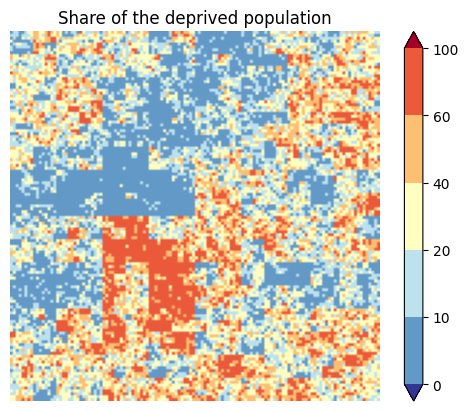

In [8]:
cmap = mpl.cm.RdYlBu_r
bounds = [0, 10, 20, 40, 60, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
ax.set_axis_off();
ax.set_title('Share of the deprived population');
ax.imshow(cmap(norm(ratio)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax);

### Calcul d'entropie

In [66]:
lnc = multivariate_lognormal_cascade(6, sigma1=.2, sigma2=.4, corr=.0)
pop = lnc[:,:,0]

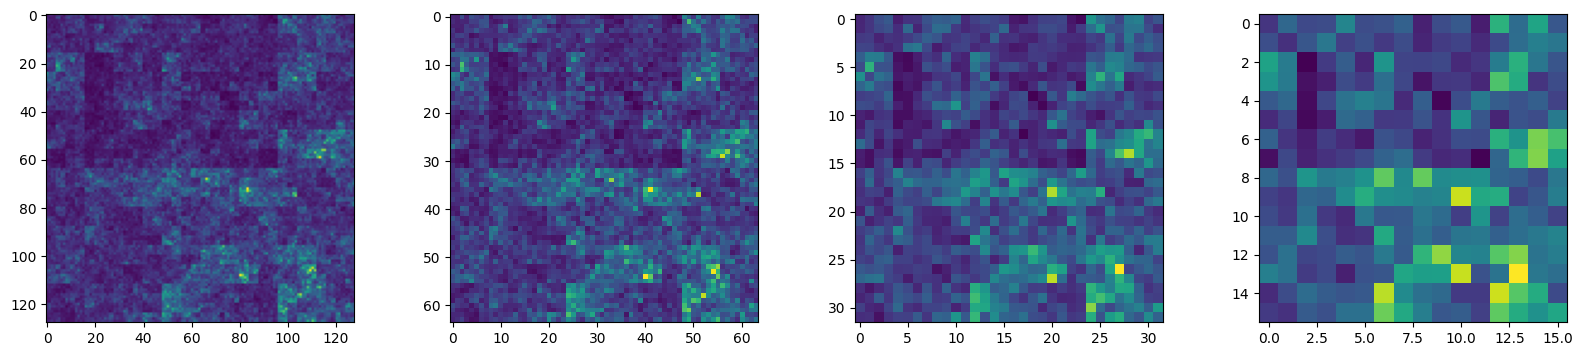

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
  axs[i].imshow(small_arr)

In [112]:
lnc = multivariate_lognormal_cascade(6, sigma1=.4, sigma2=.4, corr=.0)
pop = lnc[:,:,0]

entropies =  []
scales = np.array([i for i in range(4)])
for i in scales:
    small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
    entropies.append(-np.sum(small_arr * np.log2(small_arr)))
entropies = np.array(entropies)
print(entropies)
print(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))


[13.32294251 11.41126679  9.51998243  7.63219829]
1.896351701264622


In [107]:
mu=0.0001
sigma = 2

samples = np.exp(np.random.normal(mu, sigma, size=4))
samples = samples / samples.sum()
estimate = np.sum(samples * np.log2(samples))
print("Estimation Monte Carlo =", estimate)

Estimation Monte Carlo = -0.46316597412883975


In [74]:
np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2)

np.float64(-1.2752244843871057)